In [3]:
# Import public packages and functions
import os
import pandas as pd
import numpy as np
import sys
import json
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp

import warnings
warnings.filterwarnings("ignore")

# inserting the lib folder to the compiler
sys.path.insert(0, './lib')
sys.path.insert(0, './utils/')

import utils_misc, utils_io
from lib_data import DATA_IO

In [4]:
fs                      = 2048
PATH_CURR               = os.path.abspath(os.curdir)    # current code
PATH                    = (str(Path(PATH_CURR).parent)) # data repository: upper directory where datasets situated
df_TAPPING_MOTOR_events = pd.read_pickle(DATA_IO.path_events + "LFP_TAPPING_EVENTS_MOTOR_AREA.pkl")
df_TAPPING_MOTOR_events = df_TAPPING_MOTOR_events[df_TAPPING_MOTOR_events.patient != "019"]

In [5]:
df_controlateral        = df_TAPPING_MOTOR_events[df_TAPPING_MOTOR_events.event_laterality != df_TAPPING_MOTOR_events.LFP_hemisphere]
df_controlateral        = utils_misc.get_onset_and_offset_aligned_recordings(df_controlateral, fs=fs)
df_controlateral        = df_controlateral[["patient", "LFP_hemisphere", "LFP_channel", "recording_onset_aligned","recording_offset_aligned","dyskinesia_arm"]]
df_controlateral.reset_index(inplace=True, drop=True)

baseline_recordings = utils_io.load_baseline_recordings(recording_type="LFP")

# MNE Transformation

In [9]:
from mne.time_frequency import tfr_array_morlet, tfr_array_multitaper

In [346]:
patient = "012"

In [348]:
df_controlateral[df_controlateral.dyskinesia_arm!="none"].patient.value_counts()

patient
008    524
012    508
110    407
021    182
009    140
105     72
022     56
102     51
020     48
023     20
108     16
014      6
013      5
Name: count, dtype: int64

In [350]:
dataset               = df_controlateral[df_controlateral.patient == patient]
dataset               = dataset[dataset.dyskinesia_arm!="none"]
dataset["hemisphere"] = dataset.LFP_hemisphere
dataset["channel"]    = dataset.LFP_channel
dataset.reset_index(inplace=True, drop=True)

In [352]:
df_TF = pd.DataFrame(columns=["patient","hemisphere","channel","onset_aligned_norm","offset_aligned_norm","onset_aligned","offset_aligned","severity"])

hemispheres = list(dataset.hemisphere.unique())

for hemisphere in hemispheres:
    
    channels                    = list(dataset[dataset.hemisphere==hemisphere].channel.unique())
    
    for channel in channels:

        print(hemisphere + " - " + channel)

        row               = {}
        row["patient"]    = patient
        row["hemisphere"] = hemisphere
        row["channel"]    =  channel
        
        onset_aligned  = list(dataset[(dataset.hemisphere==hemisphere) & (dataset.channel==channel)].recording_onset_aligned)
        onset_aligned  = np.reshape(onset_aligned, (len(onset_aligned), 1, len(onset_aligned[0])))
        offset_aligned = list(dataset[(dataset.hemisphere==hemisphere) & (dataset.channel==channel)].recording_offset_aligned)
        offset_aligned = np.reshape(offset_aligned, (len(offset_aligned), 1, len(offset_aligned[0])))

        # get time-frequency representation of onset and offset aligned events
        onset_spectograms  = tfr_array_multitaper(onset_aligned , sfreq=fs, n_cycles=np.linspace(4,90,87) / 1, freqs=np.linspace(4,90,87), output='power', verbose=False)
        offset_spectograms = tfr_array_multitaper(offset_aligned, sfreq=fs, n_cycles=np.linspace(4,90,87) / 1, freqs=np.linspace(4,90,87), output='power', verbose=False)
        #onset_spectograms  = 10*np.log10(onset_spectograms)
        #offset_spectograms = 10*np.log10(offset_spectograms)
        
        onset_tfr_average  = np.nanmean(onset_spectograms, axis=0)[0]
        offset_tfr_average = np.nanmean(offset_spectograms, axis=0)[0]

        # get time-frequency representation of onset and offset aligned channel baseline
        channel_baseline   = baseline_recordings[patient][hemisphere][channel]
        channel_baseline   = channel_baseline[~np.isnan(channel_baseline)] # remove npp.nan elements
        channel_baseline   = np.reshape(channel_baseline, (1,1, len(channel_baseline)))
        baseline_tfr       = tfr_array_multitaper(channel_baseline , sfreq=fs, n_cycles=np.linspace(4,90,87) / 1, freqs=np.linspace(4,90,87), output='power', verbose=False)
        baseline_tfr_avg   = np.mean(baseline_tfr, axis=3)[0][0]
        baseline_tfr_avg   = baseline_tfr_avg[:, np.newaxis]  # shape (87, 1)
        
        # normalize event spectrogram based on baseline spectograms
        onset_tfr_norm     = ((onset_tfr_average - baseline_tfr_avg) /  (baseline_tfr_avg)) * 100
        offset_tfr_norm    = ((offset_tfr_average - baseline_tfr_avg) / (baseline_tfr_avg)) * 100

        row["onset_aligned_norm"]   = onset_tfr_norm
        row["offset_aligned_norm"]  = offset_tfr_norm
        row["onset_aligned"]        = onset_tfr_average
        row["offset_aligned"]       = offset_tfr_average
        row["severity"]             = "LID"
        
        df_TF.loc[len(df_TF)]  = row

left - 05-02
left - 08-05
left - 08-06
left - 08-07
left - 06-03
left - 07-04
right - 02-01
right - 03-01
right - 04-01
right - 05-02


In [353]:
#baseline_spectogram_avg = np.nanmean(channel_tap_onset_spectograms, axis=0)[0] # since we have single channel
time_vector    = np.linspace(-2,2,fs*4)

In [354]:
patient_onset  = np.mean(df_TF.onset_aligned.tolist(), axis=0)
patient_offset = np.mean(df_TF.offset_aligned.tolist(), axis=0)

In [355]:
patient_onset_norm  = np.mean(df_TF.onset_aligned_norm.tolist(), axis=0)
patient_offset_norm = np.mean(df_TF.offset_aligned_norm.tolist(), axis=0)

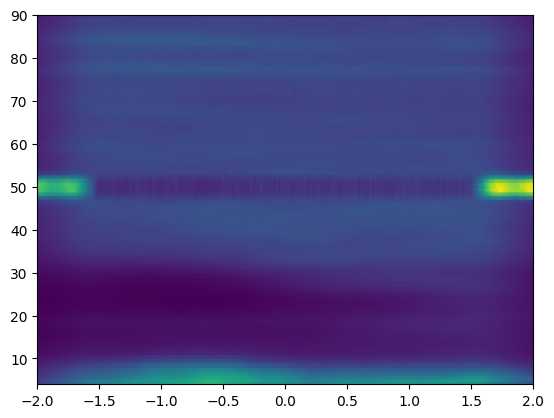

In [379]:
plt.pcolormesh(time_vector, np.linspace(4, 90, 87), patient_offset_norm, shading='gouraud')

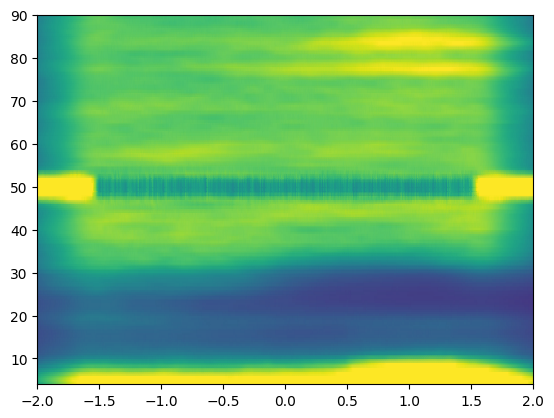

In [368]:
plt.pcolormesh(time_vector, np.linspace(4, 90, 87), patient_onset_norm, shading='gouraud', vmin=-120, vmax=50)

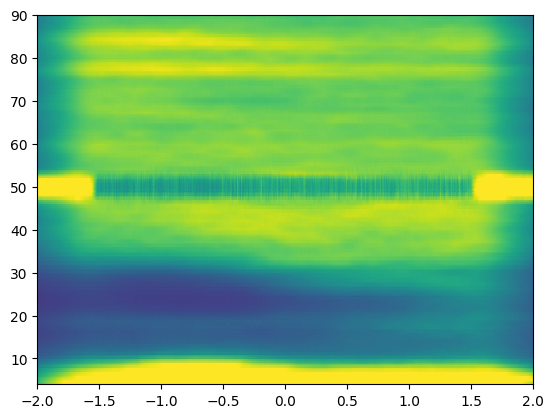

In [369]:
plt.pcolormesh(time_vector, np.linspace(4, 90, 87), patient_offset_norm, shading='gouraud', vmin=-120, vmax=50)

In [370]:
freqs           = np.linspace(4, 90, 87)

freq_mask       = np.where((freqs>=20) & (freqs<=35))

beta_timeseries = patient_offset_norm[freq_mask,:]
beta_timeseries = np.mean(beta_timeseries[0], axis = 0)


np.shape(patient_offset_norm)

(87, 8192)

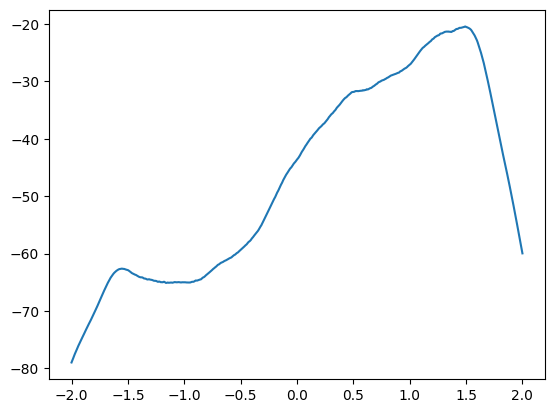

In [371]:
plt.plot(time_vector, beta_timeseries)

TypeError: Dimensions of C (87, 493569) are incompatible with X (8192) and/or Y (87); see help(pcolormesh)

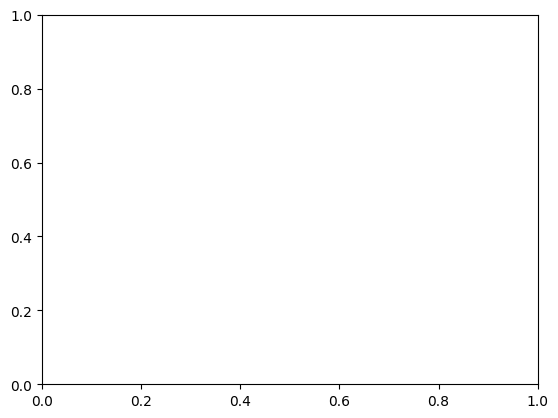

In [366]:
plt.pcolormesh(time_vector, np.linspace(4, 90, 87), baseline_tfr[0][0], shading='gouraud', vmin=1e-11, vmax=1e-9)

In [186]:
time_vector = np.linspace(0,len(baseline_tfr[0][0])/fs, len(baseline_tfr[0][0][0]))

In [188]:
len(time_vector)

493569

left - 05-02
left - 08-05
left - 08-06
left - 08-07
left - 06-03
left - 07-04
right - 02-01
right - 03-01
right - 04-01
right - 05-02


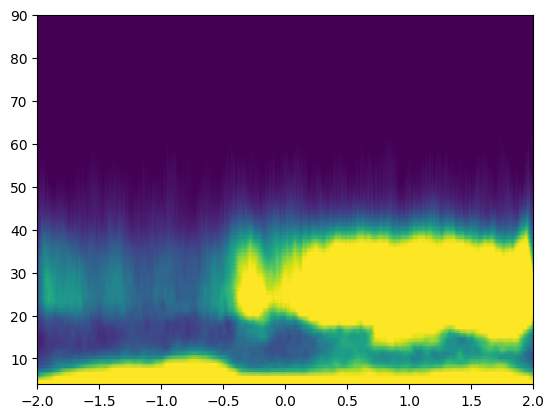

In [172]:
for index, row in df_TF.iterrows():
    print(row.hemisphere + " - " + row.channel)
    plt.pcolormesh(time_vector, np.linspace(4, 90, 87), row.offset_aligned, shading='gouraud', vmin= 1e-10, vmax=1e-9)

In [331]:
a = np.nanmean(channel_tap_onset_spectograms, axis=0)[0]

In [333]:
np.shape(a)

(87, 8192)

In [327]:
np.shape(channel_tap_onset_spectograms)

(50, 1, 87, 8192)

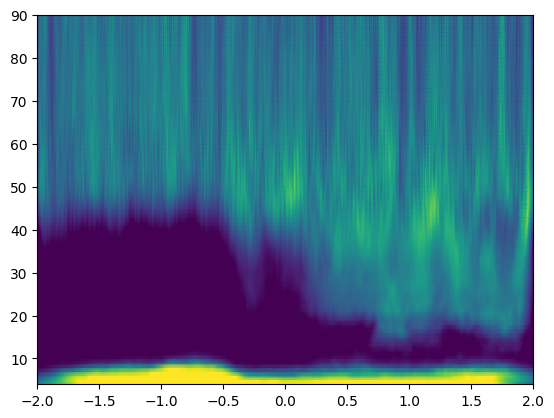

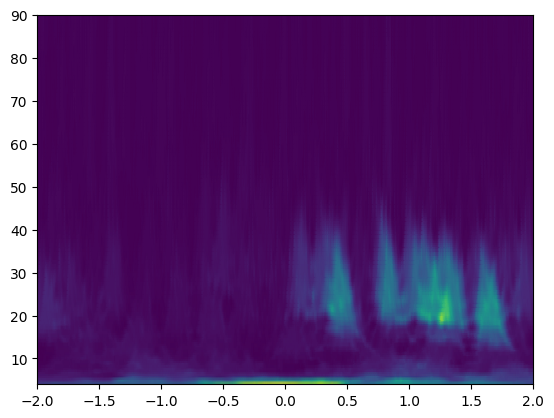

In [97]:
plt.pcolormesh(time_vector, np.linspace(4, 90, 87), channel_tap_offset_spectograms[1][0], shading='gouraud')

In [110]:
onset_mean  = np.nanmean(channel_tap_onset_spectograms, axis=0)[0]
offset_mean = np.nanmean(channel_tap_offset_spectograms, axis=0)[0]

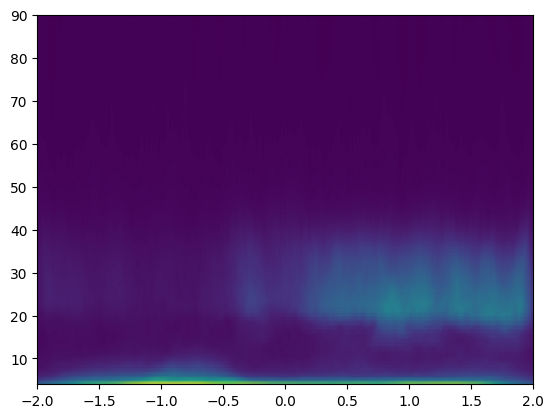

In [112]:
plt.pcolormesh(time_vector, np.linspace(4, 90, 87), offset_mean, shading='gouraud')

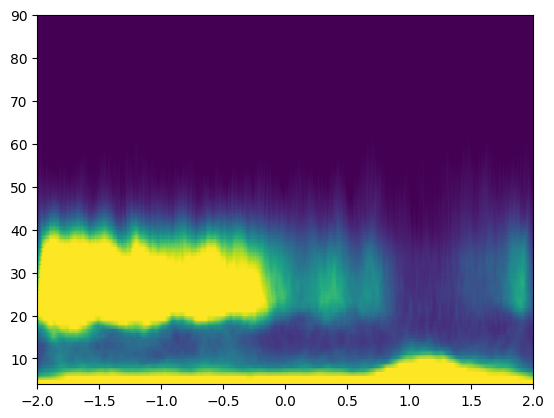

In [126]:
plt.pcolormesh(time_vector, np.linspace(4, 90, 87), onset_mean, shading='gouraud', vmin= 1e-10, vmax=1e-9)

In [116]:
onset_mean.min()

3.319972866299999e-11

In [118]:
onset_mean.max()

6.80670098082088e-09